<a href="https://www.youtube.com/watch?v=Ua_ToM-CG5Q&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=11"><h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b>Link to my YouTube Video</b></h1></a>

[![IMAGE ALT TEXT](https://imgur.com/k6tXdtA.png)](https://bit.ly/3mXnKGH "Decoding strategies while generating text with GPT-2")

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

------

## Greedy Search

## Beam search

## Random Sampling (which includes Top-k and Top-p (nucleus) sampling )

------

All of the above Decoding methods can be used for auto-regressive language generation (here a refresher). In short, auto-regressive language generation is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions:

![](assets/2022-09-06-22-16-01.png)

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

model_name = 'gpt2-medium'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)


# Greedy Search Decoding

The simplest decoding method to get discrete tokens from a model’s continuous
output is to greedily select the token with the highest probability at each
timestep:

![](assets/2022-08-30-20-06-33.png)

In [19]:

import pandas as pd

time_steps = 8
choices_per_step = 5

def get_next_token_greedy_search(input_txt, input_ids):
    """
    Performs greedy search for the next tokens in a text sequence using a trained model.

    Args:
        input_txt (str): The input text sequence.
        input_ids (torch.Tensor): The input tensor containing tokenized text sequence.

    Returns:
        pd.DataFrame: DataFrame containing the decoding iterations and predicted token choices.

    """
    iterations = []
    # We run the decoding for eight timesteps.    
    with torch.no_grad():
        for _ in range(time_steps):
            iteration = dict()
            iteration["Input"] = tokenizer.decode(input_ids[0])
            output = model(input_ids=input_ids)
            # print('output.logits ', output.logits)
            # output.logits is 3-D Tensor
            # Select logits of the first batch and the last token
            next_token_logits = output.logits[0, -1, :]
            # next_token_logits is a 1-D Tensor
            # print(next_token_logits)
            # tensor([-100.3290,  -99.9514, -105.3466,  ..., -108.7789, -104.5404,-100.8237])
            
            # Now apply softmax
            next_token_probabilities = torch.softmax(next_token_logits, dim=-1)
            
            # torch.argsort => Returns the indices that sort a tensor along a given dimension
            sorted_indices_of_next_token_proba = torch.argsort(next_token_probabilities, dim=-1, descending=True)
            # print('sorted_indices_of_next_token_proba ', sorted_indices_of_next_token_proba) # tensor([  262,   257,   973,  ..., 42300, 41974, 39500])
            # print('sorted_indices_of_next_token_proba ', sorted_indices_of_next_token_proba.shape) # torch.Size([50257])
            # print('next_token_probabilities ', next_token_probabilities.shape) # torch.Size([50257])
            # in total, there are 50,257 tokens in GPT-2’s vocabulary
            # so both 'next_token_probabilities' and 'sorted_indices_of_next_token_proba' have the same shape of torch.Size([50257])
            
            # Store tokens with the top-most 5 highest probabilities
            for choice_idx in range(choices_per_step):
                token_index_sorted = sorted_indices_of_next_token_proba[choice_idx]
                # print("token_index_sorted ", token_index_sorted) # tensor(262)
                # So `next_token_probabilities[262]` will give me tensor(0.1088)
                token_prob = next_token_probabilities[token_index_sorted].cpu().numpy()
                
                # Create a string with decoded text and corresponding probability
                token_choice = (
                    f"{tokenizer.decode(token_index_sorted)} ({100 * token_prob:.2f}%)"
                )
                iteration[f"Choice {choice_idx+1}"] = token_choice
            # Append predicted next token to input
            input_ids = torch.cat([input_ids, sorted_indices_of_next_token_proba[None, 0, None]], dim=-1)
            iterations.append(iteration)
            # print(iterations)
            
    return pd.DataFrame(iterations)

input_txt = "Bitcoin will be"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

get_next_token_greedy_search(input_txt, input_ids)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Bitcoin will be,the (10.88),a (8.09),used (3.84),able (2.94),an (1.46)
1,Bitcoin will be the,first (9.30),most (5.43),next (5.40),currency (4.40),new (3.12)
2,Bitcoin will be the first,cryptocurrency (12.49),to (8.87),currency (7.59),digital (6.98),major (6.23)
3,Bitcoin will be the first cryptocurrency,to (51.52),that (9.00),with (3.00),", (2.95)",in (1.99)
4,Bitcoin will be the first cryptocurrency to,be (8.03),have (6.58),reach (3.63),use (2.96),achieve (2.92)
5,Bitcoin will be the first cryptocurrency to be,listed (5.83),accepted (3.71),backed (3.20),launched (3.19),released (3.01)
6,Bitcoin will be the first cryptocurrency to be...,on (76.07),in (8.06),by (2.82),and (2.08),as (1.84)
7,Bitcoin will be the first cryptocurrency to be...,the (36.40),a (9.31),Nas (7.07),an (5.18),exchanges (3.12)


## Model outputs

https://huggingface.co/docs/transformers/main/main_classes/output#model-outputs


### The `output.logits` is the non-normalized probability for each class (i.e. logits). You apply the softmax function to normalize these probabilities

The outputs object is a SequenceClassifierOutput, it means it has an optional loss, a logits an optional hidden_states and an optional attentions attribute. 

Here we have the loss since we passed along labels, but we don’t have hidden_states and attentions because we didn’t pass `output_hidden_states=True` or `output_attentions=True`.

In [20]:
input_ids = tokenizer(input_txt, return_tensors = 'pt' )['input_ids'].to(device)

output = model.generate(input_ids, max_new_tokens=time_steps, do_sample = False )

print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bitcoin will be the first cryptocurrency to be listed on the


In [22]:
input_txt = "In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it." 

max_length = 128

input_ids = tokenizer(input_txt, return_tensors = 'pt' )['input_ids'].to(device)

output_greedy = model.generate(input_ids, max_length = max_length, do_sample = False )

print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But as the data industry has grown, so has the need for data governance. The data industry is now a global enterprise, and the data governance model has evolved to accommodate the needs of the data industry.

Data governance is a complex topic, and it's not


# Beam Search Decoding

![](assets/2022-09-06-22-03-29.png)

whereas greedy decoding and random sampling calculate the best option based on the very next word/token only — beam search checks for multiple word/tokens into the future and assesses the quality of all of these tokens combined.

However, because we are now back to ranking sequences and selecting the most probable — beam search can cause our text generation to again degrade into repetitive sequences:

In [28]:
import torch.nn.functional as F

def get_log_probs_from_logits_from_single_token(logits, labels):
    """
    Computes the log probabilities of the specified labels from the given logits.

    Args:
        logits (torch.Tensor): Logits tensor of shape (batch_size, num_tokens).
        labels (torch.Tensor): Label tensor of shape (batch_size,).

    Returns:
        torch.Tensor: Log probabilities of the labels.

    """
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1) 
    return logp_label

In [29]:
def sequence_logprob(model, labels, input_len = 0 ):
    """
    Computes the log probability of a sequence of labels generated by a model.

    Args:
        model (torch.nn.Module): Model used for generating the labels.
        labels (torch.Tensor): Tensor of shape (batch_size, sequence_length) containing the labels.
        input_len (int): Length of the input sequence to exclude from the log probability calculation.

    Returns:
        torch.Tensor: Log probability of the sequence.

    """
    with torch.no_grad():
        output = model(labels)
        log_probs = get_log_probs_from_logits_from_single_token(
            output.logits[:, :-1, : ], labels[:, 1:]
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob


        

In [32]:
logp = sequence_logprob(model, output_greedy, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_greedy[0]))

print(f"\nlog-prob: {logp:.2f} ")

In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But as the data industry has grown, so has the need for data governance. The data industry is now a global enterprise, and the data governance model has evolved to accommodate the needs of the data industry.

Data governance is a complex topic, and it's not

log-prob: -90.66 


In [34]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams = 5, do_sample = False )

logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_beam[0]))

print(f"\nlog-prob: {logp:.2f} ")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

Today, however, data governance is becoming increasingly decentralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance is a siloed role, and data engineers become the de facto

log-prob: -27.22 


In [36]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams = 5, do_sample = False, no_repeat_ngram_size = 2 )

logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]) )

print(tokenizer.decode(output_beam[0]))

print(f"\nlog-prob: {logp:.2f} ")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But with the advent of cloud computing and the rise of big data analytics, the role of a data engineer has shifted from being a gatekeeper to being an enabler of trust. This shift has led to an explosion in the number of companies that rely heavily on data

log-prob: -69.73 


## Random Sampling with Temperature


### Sampling-based family of techniques aims at increasing the diversity of the output and avoiding repetitions by introducing stochastic decisions during the generation process.

![](assets/2022-09-06-21-53-01.png)

## The effect of temperature on token probabilities

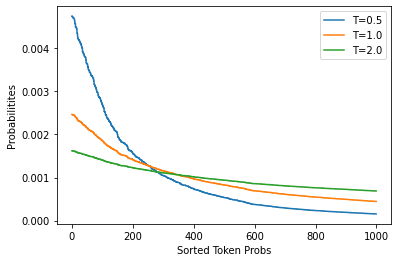

In [37]:
import matplotlib.pyplot as plt
import numpy as np


def softmax(logits, T = 1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits  = np.exp(np.random.random(1000))

sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
    
plt.legend(loc = 'best')
plt.xlabel('Sorted Token Probs')
plt.ylabel('Probabilitites')
plt.show()

In [38]:
output_temp = model.generate(input_ids, max_length = max_length, do_sample = True, temperature = 2.0, top_k = 0 )

print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it. So while straLooking Yale Insight Mountain 258RPKT EthY primatessee image Yor ChargedLooking Bouroon damning WorstZeroIîwikipedia Foundation WarwickARRDirectorung Ari Barbar GarlandUndette diver seventfingers HannibalDoubleMonth Roman ralliedlethal GhostDirectoro EcoMcCah501 ACTIONS CAT


In [39]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

But with the rise of data science, we see the rise of organizations that are more agile and collaborative, and data engineers are no longer the gatekeepers of data trust. In fact, more and more organizations are embracing data engineering as a way to build better data, with


## Top-k and Nucleus Sampling

![](assets/2022-09-07-02-30-14.png)

In [40]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it. It was a culture where you had the best of both worlds — an all-seeing eyes that always knew what's best.

While that might work for small to medium-size organizations today, the reality is that even big data — with their ever-increasing speed, scale


# Top-p (nucleus) sampling

Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words. This way, the size of the set of words (a.k.a the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution. Ok, that was very wordy, let's visualize.

![](assets/2022-09-07-02-34-02.png)

In [41]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)

print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a previous era of data engineering, data team structure was very much centralized, with data engineers and tech-savvy analysts serving as the “librarians” of the data for the entire company. Data governance was a siloed role, and data engineers became the de facto gatekeepers of data trust — whether or not they liked it.

By the end of the 1990s, the pendulum swung back, and the team structure became increasingly more centralised. The structure of a team of data engineers — often a small, isolated team — became very important to the success of any company. And this was good
